<a href="https://colab.research.google.com/github/paulsoriiiano/genre_classifier/blob/main/fma_small_mfccs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import os

import IPython.display as ipd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as skl
import sklearn.utils, sklearn.preprocessing, sklearn.decomposition, sklearn.svm
import librosa
import librosa.display

plt.rcParams['figure.figsize'] = (17, 5)

In [3]:
# Code provided by the paper to load the dataframe
import ast
def load(filepath):

    filename = os.path.basename(filepath)

    if 'features' in filename:
        return pd.read_csv(filepath, index_col=0, header=[0, 1, 2])

    if 'echonest' in filename:
        return pd.read_csv(filepath, index_col=0, header=[0, 1, 2])

    if 'genres' in filename:
        return pd.read_csv(filepath, index_col=0)

    if 'tracks' in filename:
        tracks = pd.read_csv(filepath, index_col=0, header=[0, 1])

        COLUMNS = [('track', 'tags'), ('album', 'tags'), ('artist', 'tags'),
                   ('track', 'genres'), ('track', 'genres_all')]
        for column in COLUMNS:
            tracks[column] = tracks[column].map(ast.literal_eval)

        COLUMNS = [('track', 'date_created'), ('track', 'date_recorded'),
                   ('album', 'date_created'), ('album', 'date_released'),
                   ('artist', 'date_created'), ('artist', 'active_year_begin'),
                   ('artist', 'active_year_end')]
        for column in COLUMNS:
            tracks[column] = pd.to_datetime(tracks[column])

        SUBSETS = ('small', 'medium', 'large')
        try:
            tracks['set', 'subset'] = tracks['set', 'subset'].astype(
                    'category', categories=SUBSETS, ordered=True)
        except (ValueError, TypeError):
            # the categories and ordered arguments were removed in pandas 0.25
            tracks['set', 'subset'] = tracks['set', 'subset'].astype(
                     pd.CategoricalDtype(categories=SUBSETS, ordered=True))

        COLUMNS = [('track', 'genre_top'), ('track', 'license'),
                   ('album', 'type'), ('album', 'information'),
                   ('artist', 'bio')]
        for column in COLUMNS:
            tracks[column] = tracks[column].astype('category')

        return tracks


In [4]:
# File URLs from GitHub
tracks_url = "https://github.com/paulsoriiiano/genre_classifier/blob/b1dc82084856ffafc4d7d4caed27d68711108f7c/fma_data/tracks.csv?raw=true"
genres_url = "https://github.com/paulsoriiiano/genre_classifier/blob/b1dc82084856ffafc4d7d4caed27d68711108f7c/fma_data/genres.csv?raw=true"
features_url = "https://github.com/paulsoriiiano/genre_classifier/blob/b1dc82084856ffafc4d7d4caed27d68711108f7c/fma_data/features.csv?raw=true"
echonest_url = "https://github.com/paulsoriiiano/genre_classifier/blob/b1dc82084856ffafc4d7d4caed27d68711108f7c/fma_data/echonest.csv?raw=true"

In [6]:
# Read tables
tracks = load(tracks_url)
genres = load(genres_url)
features = load(features_url)
echonest = load(echonest_url)

### MFCC and fma_small subsets

In [7]:
# Create the small subset
fma_small = tracks.loc[tracks['set', 'subset'] == 'small']
fma_small = pd.concat([fma_small[('set', 'split')], fma_small[('track', 'genre_top')]], axis=1) # Select only genre and train-test split labels
fma_small.columns = ['split', 'genre'] # Rename columns
fma_small['genre'] = fma_small['genre'].cat.remove_unused_categories() # Only select top 8 genres
fma_small['genre'].value_counts() # Data validation

,count
genre,
Electronic,1000
Experimental,1000
Folk,1000
Hip-Hop,1000
Instrumental,1000
International,1000
Pop,1000
Rock,1000


<Axes: xlabel='count', ylabel='genre'>

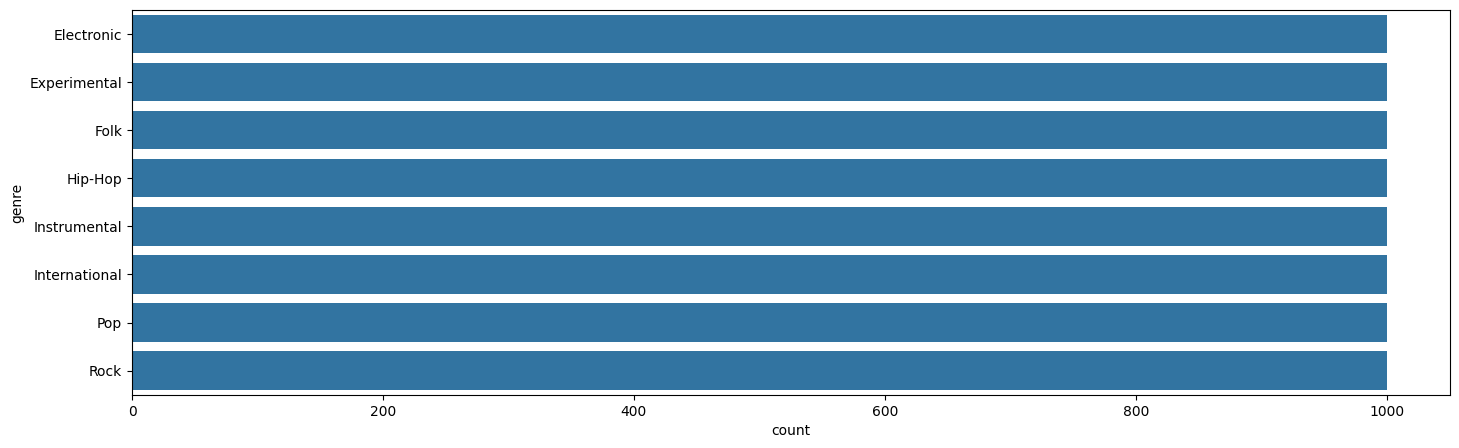

In [8]:
sns.countplot(y='genre', data=fma_small.groupby('genre', observed=True).filter(lambda g: len(g) > 1))

In [9]:
# Get mfcc features from features dataframe
all_mfcc = features['mfcc']


# Split each stats for mfcc
kurtosis_mfcc = all_mfcc['kurtosis']
max_mfcc = all_mfcc['max']
mean_mfcc = all_mfcc['mean']
median_mfcc = all_mfcc['median']
min_mfcc = all_mfcc['min']
skew_mfcc = all_mfcc['skew']
std_mfcc = all_mfcc['std']

# If using all mfcc features
all_mfcc_flat = all_mfcc
all_mfcc_flat.columns = all_mfcc_flat.columns.to_flat_index().str.join('_')


In [10]:
# Create joined dataframes with fma_small and mfcc features
small_kurt_mfcc = pd.merge(left=fma_small, right=kurtosis_mfcc, left_index=True, right_index=True)
small_max_mfcc = pd.merge(left=fma_small, right=max_mfcc, left_index=True, right_index=True)
small_mean_mfcc = pd.merge(left=fma_small, right=mean_mfcc, left_index=True, right_index=True)
small_median_mfcc = pd.merge(left=fma_small, right=median_mfcc, left_index=True, right_index=True)
small_min_mfcc = pd.merge(left=fma_small, right=min_mfcc, left_index=True, right_index=True)
small_skew_mfcc = pd.merge(left=fma_small, right=skew_mfcc, left_index=True, right_index=True)
small_std_mfcc =  pd.merge(left=fma_small, right=std_mfcc, left_index=True, right_index=True)

In [11]:
test_dataframes = [small_kurt_mfcc, small_max_mfcc, small_mean_mfcc, small_median_mfcc, small_min_mfcc, small_skew_mfcc, small_std_mfcc]
test_dataframes_names = ['kurtosis', 'max', 'mean', 'median', 'min', 'skew', 'std']
tests = {k:v for k,v in zip(test_dataframes_names, test_dataframes)}

### Model Training and Testing

#### Logistic Regression with each MFCC stat

In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, ConfusionMatrixDisplay

In [13]:
accuracy_scores = []
f1_micro_scores = []
f1_macro_scores = []
f1_weighted_scores = []
classes = []
confusion_matrices = []

for label in test_dataframes_names:
  regr = LogisticRegression(random_state=17, solver='lbfgs', multi_class='multinomial', max_iter=10000)
  test_df = tests[label]
  train_data = test_df[test_df['split'] == 'training']

  test_data = test_df[test_df['split'] == 'test']
  # cv_data = test_df[~(test_df.index.isin(train_data.index) | test_df.index.isin(test_data.index))]
  # print(f"df size: {test_df.shape[0]}, X size: {X.shape[0]}, y size: {y.shape[0]}, cv size: {cv.shape[0]}")
  # (np.array(test_df.index) == (np.sort(np.hstack((X.index, y.index, cv.index)).ravel()))).all() # Checks that there's no data leak
  X_train = train_data.iloc[:, 2:]
  y_train = train_data.iloc[:, 1]
  X_test = test_data.iloc[:, 2:]
  y_test = test_data.iloc[:, 1]


  # LabelEncode categorical target variable
  le = LabelEncoder()
  y_train = le.fit_transform(y_train)
  y_test = le.fit_transform(y_test)
  classes.append(le.classes_)

  # Train and test model
  regr.fit(X_train, y_train)
  y_pred = regr.predict(X_test)

  # Check metrics
  accuracy_scores.append(accuracy_score(y_test, y_pred))
  f1_micro_scores.append(f1_score(y_test, y_pred, average='micro'))
  f1_macro_scores.append(f1_score(y_test, y_pred, average='macro'))
  f1_weighted_scores.append(f1_score(y_test, y_pred, average='weighted'))
  confusion_matrices.append(confusion_matrix(y_test, y_pred))

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and wi

In [19]:
test_results = pd.DataFrame({'accuracy': accuracy_scores, 'f1_micro': f1_micro_scores, 'f1_macro': f1_macro_scores, 'f1_weighted': f1_weighted_scores}, index=test_dataframes_names)
test_results.index.name = 'MFCC stats'
test_results

,accuracy,f1_micro,f1_macro,f1_weighted
MFCC stats,,,,
kurtosis,0.28000,0.28000,0.253171,0.253171
max,0.33625,0.33625,0.318204,0.318204
mean,0.36000,0.36000,0.348898,0.348898
median,0.36125,0.36125,0.352712,0.352712
min,0.30375,0.30375,0.283726,0.283726
skew,0.29375,0.29375,0.283420,0.283420
std,0.32500,0.32500,0.306004,0.306004


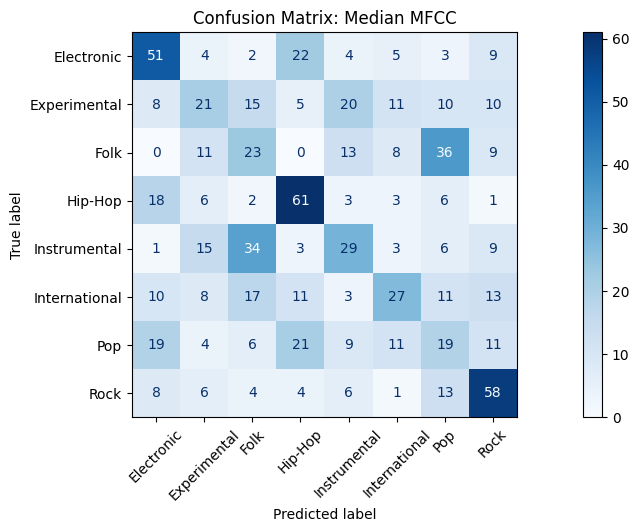

In [16]:
# Uncomment which confusion matrix you want to see
# disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrices[0], display_labels=classes[0]) # kurtosis
# disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrices[1], display_labels=classes[1]) # max
# disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrices[2], display_labels=classes[2]) # mean
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrices[3], display_labels=classes[3]) # median
# disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrices[4], display_labels=classes[4]) # min
# disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrices[5], display_labels=classes[5]) # skew
# disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrices[6], display_labels=classes[6]) # std

disp.plot(xticks_rotation=45, cmap='Blues')

# Set the title
disp.ax_.set_title("Confusion Matrix: Median MFCC")

plt.show()

#### Logistic Regression with all MFCC stats

In [17]:
small_all_mfcc =  pd.merge(left=fma_small, right=all_mfcc_flat, left_index=True, right_index=True)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Accuracy:  0.41
F1 micro:  0.41
F1 macro:  0.4045923860385917
F1 weighted:  0.40459238603859177


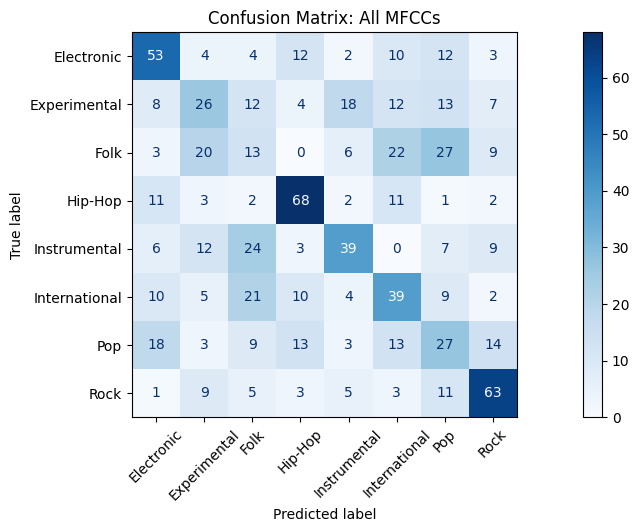

In [18]:
regr = LogisticRegression(random_state=17, solver='newton-cg', multi_class='multinomial', max_iter=100000)
test_df = small_all_mfcc
train_data = test_df[test_df['split'] == 'training']

test_data = test_df[test_df['split'] == 'test']
# cv_data = test_df[~(test_df.index.isin(train_data.index) | test_df.index.isin(test_data.index))]
# print(f"df size: {test_df.shape[0]}, X size: {X.shape[0]}, y size: {y.shape[0]}, cv size: {cv.shape[0]}")
# (np.array(test_df.index) == (np.sort(np.hstack((X.index, y.index, cv.index)).ravel()))).all() # Checks that there's no data leak
X_train = train_data.iloc[:, 2:]
y_train = train_data.iloc[:, 1]
X_test = test_data.iloc[:, 2:]
y_test = test_data.iloc[:, 1]


# LabelEncode categorical target variable
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.fit_transform(y_test)

# Train and test model
regr.fit(X_train, y_train)
y_pred = regr.predict(X_test)

# Check metrics
print("Accuracy: ", accuracy_score(y_test, y_pred))
print("F1 micro: ", f1_score(y_test, y_pred, average='micro'))
print("F1 macro: ", f1_score(y_test, y_pred, average='macro'))
print("F1 weighted: ", f1_score(y_test, y_pred, average='weighted'))
cm = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_pred), display_labels=le.classes_)

# Show confusion matrix
cm.plot(xticks_rotation=45, cmap='Blues')

cm.ax_.set_title("Confusion Matrix: All MFCCs")

plt.show()

#### Random Forest with selected MFCC stats

In [20]:
from sklearn.ensemble import RandomForestClassifier
import joblib

In [21]:
# For parallel computing
N_CORES = joblib.cpu_count(only_physical_cores=True)
print(f"Number of physical cores: {N_CORES}")

Number of physical cores: 1


In [23]:
train_data = test_df[test_df['split'] == 'training']
train_data.drop(columns=['split', 'genre']).head(2)

,kurtosis_01,kurtosis_02,kurtosis_03,kurtosis_04,kurtosis_05,kurtosis_06,kurtosis_07,kurtosis_08,kurtosis_09,kurtosis_10,...,std_11,std_12,std_13,std_14,std_15,std_16,std_17,std_18,std_19,std_20
track_id,,,,,,,,,,,,,,,,,,,,,
2,3.856789,1.541901,0.000816,0.330728,0.118731,-0.342687,-0.259252,0.146735,0.410656,-0.162872,...,10.059609,8.601942,9.284250,9.245516,8.520863,8.560472,7.651871,7.246555,7.077188,7.391859
5,2.624517,2.415293,0.440233,-0.782131,-0.771069,-0.724216,0.090260,0.152119,0.261731,-0.608905,...,8.863638,9.581952,8.895723,8.141456,8.201844,7.780963,7.132692,7.539753,8.452527,7.334442


In [24]:
accuracy_scores = []
f1_micro_scores = []
f1_macro_scores = []
f1_weighted_scores = []
classes = []
confusion_matrices = []

for label in test_dataframes_names:
  clf = RandomForestClassifier(n_estimators=100, n_jobs=N_CORES, random_state=17)
  test_df = tests[label]
  # Train-test split given labels in the data
  train_data = test_df[test_df['split'] == 'training']
  test_data = test_df[test_df['split'] == 'test']
  X_train = train_data.drop(columns=['split', 'genre'])
  y_train = train_data['genre']
  X_test = test_data.drop(columns=['split', 'genre'])
  y_test = test_data['genre']

  # # LabelEncode categorical target variable
  # le = LabelEncoder()
  # y_train = le.fit_transform(y_train)
  # y_test = le.fit_transform(y_test)
  # classes.append(le.classes_)

  # Train and test model
  clf.fit(X_train, y_train)
  y_pred = clf.predict(X_test)

  # Check metrics
  accuracy_scores.append(accuracy_score(y_test, y_pred))
  f1_micro_scores.append(f1_score(y_test, y_pred, average='micro'))
  f1_macro_scores.append(f1_score(y_test, y_pred, average='macro'))
  f1_weighted_scores.append(f1_score(y_test, y_pred, average='weighted'))
  confusion_matrices.append(confusion_matrix(y_test, y_pred))

In [25]:
clf_test_results = pd.DataFrame({'accuracy': accuracy_scores, 'f1_micro': f1_micro_scores, 'f1_macro': f1_macro_scores, 'f1_weighted': f1_weighted_scores}, index=test_dataframes_names)
clf_test_results.index.name = 'MFCC stats'
clf_test_results

,accuracy,f1_micro,f1_macro,f1_weighted
MFCC stats,,,,
kurtosis,0.28750,0.28750,0.269582,0.269582
max,0.36000,0.36000,0.346060,0.346060
mean,0.34125,0.34125,0.336227,0.336227
median,0.36000,0.36000,0.357020,0.357020
min,0.30625,0.30625,0.293657,0.293657
skew,0.31125,0.31125,0.301454,0.301454
std,0.35500,0.35500,0.345075,0.345075


#### Random Forest with all MFCC stats

In [62]:
from sklearn.metrics import classification_report

               precision    recall  f1-score   support

   Electronic       0.49      0.56      0.52       100
 Experimental       0.30      0.31      0.30       100
         Folk       0.25      0.25      0.25       100
      Hip-Hop       0.53      0.65      0.58       100
 Instrumental       0.47      0.37      0.42       100
International       0.43      0.47      0.45       100
          Pop       0.34      0.26      0.29       100
         Rock       0.59      0.57      0.58       100

     accuracy                           0.43       800
    macro avg       0.43      0.43      0.43       800
 weighted avg       0.43      0.43      0.43       800



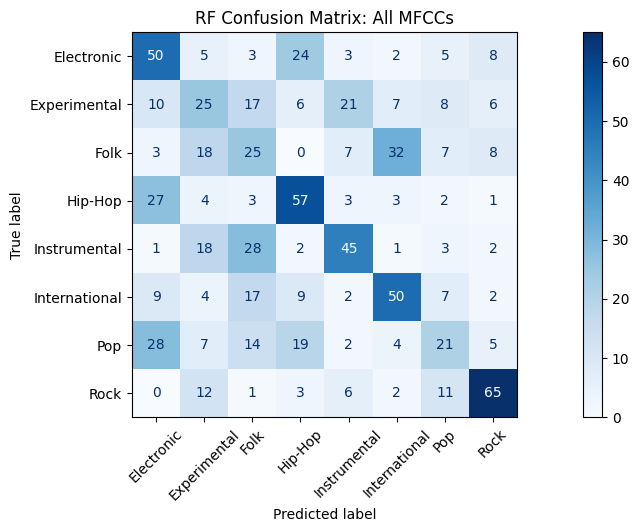

In [64]:
clf = RandomForestClassifier(n_estimators=100, n_jobs=N_CORES, random_state=17)
test_df = small_all_mfcc

# Train-test split
train_data = test_df[test_df['split'] == 'training']
test_data = test_df[test_df['split'] == 'test']
X_train = train_data.drop(columns=['split', 'genre'])
y_train = train_data['genre']
X_test = test_data.drop(columns=['split', 'genre'])
y_test = test_data['genre']


# Train and test model
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

# Check metrics
print(classification_report(y_test, y_pred, target_names=clf.classes_))

# Show confusion matrix
cm.plot(xticks_rotation=45, cmap='Blues')

cm.ax_.set_title("RF Confusion Matrix: All MFCCs")

plt.show()

In [59]:
# Check feature importances
feature_importances = pd.DataFrame({'Feature': X_train.columns, 'Importance': clf.feature_importances_}).sort_values('Importance', ascending=False)
selected_features = feature_importances[feature_importances['Importance'] > 0.006]['Feature'].values

In [60]:
len(selected_features)

83

               precision    recall  f1-score   support

   Electronic       0.39      0.50      0.44       100
 Experimental       0.27      0.25      0.26       100
         Folk       0.23      0.25      0.24       100
      Hip-Hop       0.47      0.57      0.52       100
 Instrumental       0.51      0.45      0.48       100
International       0.50      0.50      0.50       100
          Pop       0.33      0.21      0.26       100
         Rock       0.67      0.65      0.66       100

     accuracy                           0.42       800
    macro avg       0.42      0.42      0.42       800
 weighted avg       0.42      0.42      0.42       800



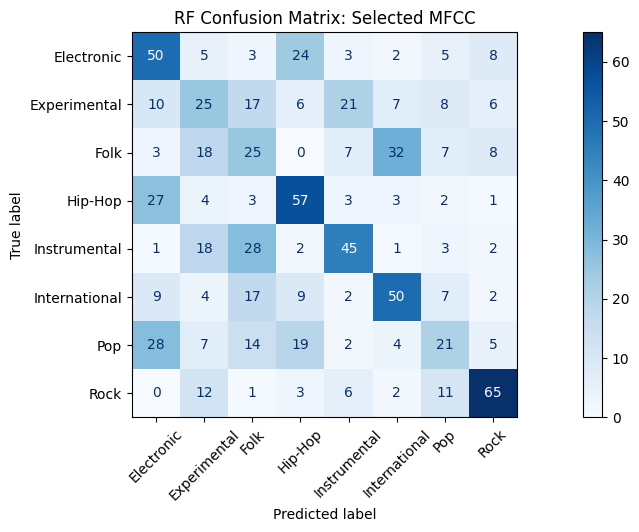

In [63]:
rf = RandomForestClassifier(n_estimators=100, n_jobs=N_CORES, random_state=17)

# Train-test with selected features
X_train_selected = train_data[selected_features]
X_test_selected = test_data[selected_features]
y_train = train_data['genre']
y_test = test_data['genre']

# Fit-predict
rf.fit(X_train_selected, y_train)
y_pred = rf.predict(X_test_selected)

# Check metrics
print(classification_report(y_test, y_pred, target_names=rf.classes_))

# Show confusion matrix
cm.plot(xticks_rotation=45, cmap='Blues')

cm.ax_.set_title("RF Confusion Matrix: Selected MFCC")

plt.show()